# Optimizer
Gets data and uses it to optimize a method (imported from method.py) using a loss function and tests it against unseen data.
TODO:
- Cross Validation implementation


In [744]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim

# Import data

In [745]:
### Load the data
data_path = 'data/survey_2022-06-08.csv'
df = pd.read_csv(data_path)
df

,1. Geschlecht:,2. Alter:,3. Körpergröße (in cm),4. Körpergewicht (in kg),8. Wie lange fahren Sie schon auf dem Bus?,10. Bitte geben Sie an ob Sie sitzen oder stehen:,11. Bitte geben Sie Ihre Position im Bus an:,"12. Bitte geben Sie an, ob sie näher einer Fenster oder dem Gang sind:",clothing_insulation,comfort
0,0,62,162,60,0,0,0.0,0,31,1.000000
1,0,36,163,65,0,0,1.0,0,21,1.666667
2,0,23,168,68,1,0,2.0,0,35,1.000000
3,0,22,178,80,0,0,3.0,1,26,1.333333
4,0,25,163,65,0,0,4.0,1,26,1.333333
5,0,27,168,57,2,0,4.0,1,26,1.666667
6,1,38,187,69,0,0,5.0,0,22,1.666667
7,1,73,167,83,0,0,5.0,1,32,2.000000
8,1,61,176,80,0,0,4.0,0,29,1.333333
9,1,47,184,81,1,1,5.0,0,22,1.333333


# Scale Data

In [746]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(df)
y = X[:,-1]
x = X[:,:-1]

# Cross Validation Split #TODO

# Train Test Split

In [747]:
from sklearn.model_selection import train_test_split
dtype = torch.float
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train = torch.tensor(x_train,dtype=dtype)
x_test = torch.tensor(x_test, dtype=dtype)
y_test = torch.tensor(y_test, dtype=dtype).reshape(-1,1)
y_train = torch.tensor(y_train, dtype=dtype).reshape(-1,1)

# Train

Epoch: 0, train loss: 0.33245787024497986, test loss: 0.22924605011940002
Epoch: 100, train loss: 0.035528458654880524, test loss: 0.017408976331353188
Epoch: 200, train loss: 0.029297564178705215, test loss: 0.015344109386205673
Epoch: 300, train loss: 0.025294430553913116, test loss: 0.01379367709159851
Epoch: 400, train loss: 0.023043271154165268, test loss: 0.013972116634249687
Epoch: 500, train loss: 0.018078619614243507, test loss: 0.01764809526503086
Epoch: 600, train loss: 0.013973762281239033, test loss: 0.02779315412044525
Epoch: 700, train loss: 0.013324899598956108, test loss: 0.03303185850381851
Epoch: 800, train loss: 0.012875688262283802, test loss: 0.03738796338438988
Epoch: 900, train loss: 0.012585114687681198, test loss: 0.04009445011615753


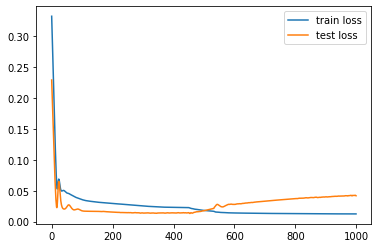

In [748]:
import time
from torch.optim.lr_scheduler import ExponentialLR
from methods import *
from torch import nn

epochs = 1000
seed=3
torch.manual_seed(seed)
method = NN(input_size=x_train.shape[1])
criterion = nn.MSELoss()
params_to_be_optimized = method.get_parameters()
optimizer = optim.Adam(params_to_be_optimized, lr=0.01)
scheduler = ExponentialLR(optimizer, gamma=0.999)
train_losses = []
test_losses = []

for epoch in range(epochs):
  iteration_time = time.time()
  optimizer.zero_grad()

  # forward pass
  y_train_predicted = method.predict(x_train)
  loss = criterion(y_train_predicted, y_train)

  # backward pass
  loss.backward()
  optimizer.step()
  scheduler.step()


  with torch.no_grad():

    y_train_predicted = method.predict(x_train)
    train_loss = criterion(y_train_predicted, y_train)
    train_losses.append(train_loss)

    y_test_predicted = method.predict(x_test)
    test_loss = criterion(y_test_predicted, y_test)
    test_losses.append(test_loss)

    if epoch%100==0:
      print(f'Epoch: {epoch}, train loss: {train_loss}, test loss: {test_loss}')


plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

# Test results

In [749]:
# Rescale test result to original values
zeros = np.zeros(x_test.shape)
test_predicted = np.concatenate((zeros, method.predict(x_test).detach().numpy()),axis=1)
test_predicted= scaler.inverse_transform(test_predicted)[:,-1]

test_target = np.concatenate((zeros, y_test.detach().numpy()),axis=1)
test_target = scaler.inverse_transform(test_target)[:,-1]

In [750]:
# Calculate percentage error
percentage_error = (test_target - test_predicted)/test_target

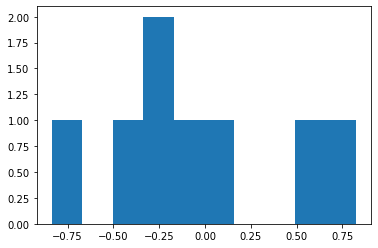

In [751]:
# Plot histogram of percentage error
plt.hist(percentage_error)
plt.show()